# Problem 2: Language Modeling with RNNs
* <b>Learning Objective:</b> In this problem, you are going to implement simple recurrent neural networks to deeply understand how RNNs works.
* <b>Provided Code:</b> We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* <b>TODOs:</b> you will firstly implement a vanilla RNN to warm up, and then implement an LSTM to train a model that can generate text using your own text source (novel, lyrics etc).

In [1]:
from lib.rnn.rnn import *
from lib.rnn.layer_utils import *
from lib.rnn.train import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Recurrent Neural Networks
We will use recurrent neural network (RNN) language models for text generation.

Please complete the TODOs in the function `VanillaRNN` of the file `lib/rnn/layer_utils.py` which should contain implementations of different layer types that are needed for recurrent neural networks.

And then, complete the TODOs in the file `lib/rnn/rnn.py` which uses these layers to implement a text generation model.

# Vanilla RNN: step forward (4 Pts)
Open the file `lib/rnn/layer_utils.py`. Implement the forward and backward passes for different types of layers that are commonly used in recurrent neural networks.

First complete the implementation of the function `step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network.

After doing so run the following code. You should see errors less than 1e-8.

In [2]:
%reload_ext autoreload

N, D, H = 3, 10, 4

rnn = VanillaRNN(D, H, init_scale=0.02, name="rnn_test")
x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)

rnn.params[rnn.wx_name] = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
rnn.params[rnn.wh_name] = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
rnn.params[rnn.b_name] = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn.step_forward(x, prev_h)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward (4 Pts)
In the `VanillaRNN` class in the file `lib/rnn/layer_utils.py` complete the `step_backward` function.

After doing so run the following to numerically gradient check the implementation. You should see errors less than `1e-8`.

In [3]:
%reload_ext autoreload

np.random.seed(231)
N, D, H = 4, 5, 6

rnn = VanillaRNN(D, H, init_scale=0.02, name="rnn_test")

x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

rnn.params[rnn.wx_name] = Wx
rnn.params[rnn.wh_name] = Wh
rnn.params[rnn.b_name] = b

out, meta = rnn.step_forward(x, h)

dnext_h = np.random.randn(*out.shape)

dx_num = eval_numerical_gradient_array(lambda x: rnn.step_forward(x, h)[0], x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(lambda h: rnn.step_forward(x, h)[0], h, dnext_h)
dWx_num = eval_numerical_gradient_array(lambda Wx: rnn.step_forward(x, h)[0], Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(lambda Wh: rnn.step_forward(x, h)[0], Wh, dnext_h)
db_num = eval_numerical_gradient_array(lambda b: rnn.step_forward(x, h)[0], b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn.step_backward(dnext_h, meta)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.473855898318782e-10
dprev_h error:  2.408484610600567e-10
dWx error:  1.264200416692046e-10
dWh error:  3.1863456358952086e-10
db error:  1.655233896888798e-11


# Vanilla RNN: forward (4 Pts)
Now that you have  completed the forward and backward passes for a single timestep of a vanilla RNN, you will see how they are combined to implement a RNN that process an entire sequence of data.

In the `VanillaRNN` class in the file `lib/rnn/layer_utils.py`, complete the function `forward`. This is implemented using the `step_forward` function that you defined above.

After doing so run the following to check the implementation. You should see errors less than `1e-7`.

In [4]:
%reload_ext autoreload

N, T, D, H = 2, 3, 4, 5

rnn = VanillaRNN(D, H, init_scale=0.02, name="rnn_test")

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

rnn.params[rnn.wx_name] = Wx
rnn.params[rnn.wh_name] = Wh
rnn.params[rnn.b_name] = b

h = rnn.forward(x, h0)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


# Vanilla RNN: backward (4 Pts)
In the file `lib/rnn/layer_utils.py`, complete the backward pass for a vanilla RNN in the function `backward` in the `VanillaRNN` class. This runs back-propagation over the entire sequence, calling into the `step_backward` function defined above.

You should see errors less than 5e-7.

In [5]:
%reload_ext autoreload

np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

rnn = VanillaRNN(D, H, init_scale=0.02, name="rnn_test")

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

rnn.params[rnn.wx_name] = Wx
rnn.params[rnn.wh_name] = Wh
rnn.params[rnn.b_name] = b

out = rnn.forward(x, h0)

dout = np.random.randn(*out.shape)

dx, dh0 = rnn.backward(dout)

dx_num = eval_numerical_gradient_array(lambda x: rnn.forward(x, h0), x, dout)
dh0_num = eval_numerical_gradient_array(lambda h0: rnn.forward(x, h0), h0, dout)
dWx_num = eval_numerical_gradient_array(lambda Wx: rnn.forward(x, h0), Wx, dout)
dWh_num = eval_numerical_gradient_array(lambda Wh: rnn.forward(x, h0), Wh, dout)
db_num = eval_numerical_gradient_array(lambda b: rnn.forward(x, h0), b, dout)

dWx = rnn.grads[rnn.wx_name]
dWh = rnn.grads[rnn.wh_name]
db = rnn.grads[rnn.b_name]

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.2600059617453742e-08
dh0 error:  8.272802161387549e-10
dWx error:  2.077530726046649e-08
dWh error:  1.5104222914511353e-08
db error:  3.7334931443820546e-10


# Word embedding: forward (4 Pts)
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In the file `lib/rnn/layer_utils.py`, implement the function `forward` in the `word_embedding` class to convert words (represented by integers) into vectors. Run the following to check the implementation. You should see error around `1e-8`.

In [6]:
%reload_ext autoreload

N, T, V, D = 2, 4, 5, 3

we = word_embedding(V, D, name="we")

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

we.params[we.w_name] = W

out = we.forward(x)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# Word embedding: backward (4 Pts)
Implement the backward pass for the word embedding function in the function `backward` in the `word_embedding` class. After doing so run the following to numerically gradient check your implementation. You should see errors less than `1e-11`.

In [7]:
%reload_ext autoreload

np.random.seed(231)

N, T, V, D = 50, 3, 5, 6

we = word_embedding(V, D, name="we")

x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

we.params[we.w_name] = W

out = we.forward(x)
dout = np.random.randn(*out.shape)
we.backward(dout)

dW = we.grads[we.w_name]

f = lambda W: we.forward(x)
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2759440934795915e-12


# Temporal Fully Connected layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. Because this is very similar to the fully connected layer that you implemented in assignment 1, we have provided this function for you in the `forward` and `backward` functions in the file `lib/rnn/layer_util.py`. Run the following to perform numeric gradient checking on the implementation. You should see errors less than 1e-9.

In [8]:
%reload_ext autoreload

np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5

t_fc = temporal_fc(D, M, init_scale=0.02, name='test_t_fc')

x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

t_fc.params[t_fc.w_name] = w
t_fc.params[t_fc.b_name] = b

out = t_fc.forward(x)

dout = np.random.randn(*out.shape)

dx_num = eval_numerical_gradient_array(lambda x: t_fc.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: t_fc.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: t_fc.forward(x), b, dout)

dx = t_fc.backward(dout)
dw = t_fc.grads[t_fc.w_name]
db = t_fc.grads[t_fc.b_name]

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  3.2269470390098687e-10
dw error:  3.8595619942595054e-11
db error:  1.1455396263586309e-11


# Temporal Softmax Cross-Entropy loss
When rolling out a RNN language model to generate a sentence, at every timestep we produce a score for each word in the vocabulary, propotional to the predicted likelihood of this word appearing at the particular timestep in the sentence. We know the ground-truth word at each timestep, so we use a softmax cross-entropy loss function to (1) compute a proper probability distribution over the words in the vocabulary at every time step and (2) use this to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

We provide this loss function for you; look at the `temporal_softmax_CE_loss` function in the file `lib/rnn/layer_utils.py`.

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx less than 1e-7.

In [9]:
%reload_ext autoreload

loss_func = temporal_softmax_CE_loss()

# Sanity check for temporal softmax loss
N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(loss_func.forward(x, y, mask))
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss = loss_func.forward(x, y, mask)
dx = loss_func.backward()

dx_num = eval_numerical_gradient(lambda x: loss_func.forward(x, y, mask), x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3026547279318357
23.026307039328714
2.2989009292538665
dx error:  4.0464746298031226e-08


# RNN for language modeling
Now that you have the necessary layers, you can combine them to build a language modeling model. Open the file `lib/rnn/rnn.py` and look at the `TestRNN` class.

For now only check the forward and backward pass of the `TestRNN` model and ignore the `TODOs` in the constructor; you will implement these later. After doing so, run the following to check the forward and backward pass using a small test case; you should see error less than `1e-10`.

In [10]:
%reload_ext autoreload

N, D, H = 10, 20, 40
V = 4
T = 13

model = TestRNN(D, H, cell_type='rnn')
loss_func = temporal_softmax_CE_loss()

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)
model.assign_params()

features = np.linspace(-1.5, 0.3, num=(N * D * T)).reshape(N, T, D)
h0 = np.linspace(-1.5, 0.5, num=(N*H)).reshape(N, H)
labels = (np.arange(N * T) % V).reshape(N, T)

pred = model.forward(features, h0)

# You'll need this
mask = np.ones((N, T))

loss = loss_func.forward(pred, labels, mask)
dLoss = loss_func.backward()

expected_loss = 51.0949189134

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  51.094918913361184
expected loss:  51.0949189134
difference:  3.881694965457427e-11


Run the following cell to perform more detailed gradient checking on the backward pass of the `TestRNN` class; you should errors around `1e-7` or less.

In [11]:
%reload_ext autoreload

np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
hidden_dim = 6
label_size = 4

labels = np.random.randint(label_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, timesteps, input_dim)
h0 = np.random.randn(batch_size, hidden_dim)

model = TestRNN(input_dim, hidden_dim, cell_type='rnn')
loss_func = temporal_softmax_CE_loss()

pred = model.forward(features, h0)

# You'll need this
mask = np.ones((batch_size, timesteps))

loss = loss_func.forward(pred, labels, mask)
dLoss = loss_func.backward()

dout, dh0 = model.backward(dLoss)

grads = model.grads

for param_name in sorted(grads):
    f = lambda _: loss_func.forward(model.forward(features, h0), labels, mask)
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

vanilla_rnn_b relative error: 9.451394e-08
vanilla_rnn_wh relative error: 3.221744e-08
vanilla_rnn_wx relative error: 9.508480e-08


# LSTM
Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants. LSTMs solve this problem by replacing the simple update rule in the forward step of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$. Crucially, the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *gate gate* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the text generation task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward (6 Pts)
Implement the forward pass for a single timestep of an LSTM in the `step_forward` function in the file `lib/rnn/layer_utils.py`. This should be similar to the `step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [12]:
%reload_ext autoreload

N, D, H = 3, 4, 5

lstm = LSTM(D, H, init_scale=0.02, name='test_lstm')

x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

lstm.params[lstm.wx_name] = Wx
lstm.params[lstm.wh_name] = Wh
lstm.params[lstm.b_name] = b

next_h, next_c, cache = lstm.step_forward(x, prev_h, prev_c)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131185818695e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward  (6 Pts)
Implement the backward pass for a single LSTM timestep in the function `step_backward` in the file `lib/rnn/layer_utils.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-6` or less.

In [13]:
%reload_ext autoreload

np.random.seed(231)

N, D, H = 4, 5, 6

lstm = LSTM(D, H, init_scale=0.02, name='test_lstm')

x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

lstm.params[lstm.wx_name] = Wx
lstm.params[lstm.wh_name] = Wh
lstm.params[lstm.b_name] = b

next_h, next_c, cache = lstm.step_forward(x, prev_h, prev_c)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm.step_forward(x, prev_h, prev_c)[0]
fh_h = lambda h: lstm.step_forward(x, prev_h, prev_c)[0]
fc_h = lambda c: lstm.step_forward(x, prev_h, prev_c)[0]
fWx_h = lambda Wx: lstm.step_forward(x, prev_h, prev_c)[0]
fWh_h = lambda Wh: lstm.step_forward(x, prev_h, prev_c)[0]
fb_h = lambda b: lstm.step_forward(x, prev_h, prev_c)[0]

fx_c = lambda x: lstm.step_forward(x, prev_h, prev_c)[1]
fh_c = lambda h: lstm.step_forward(x, prev_h, prev_c)[1]
fc_c = lambda c: lstm.step_forward(x, prev_h, prev_c)[1]
fWx_c = lambda Wx: lstm.step_forward(x, prev_h, prev_c)[1]
fWh_c = lambda Wh: lstm.step_forward(x, prev_h, prev_c)[1]
fb_c = lambda b: lstm.step_forward(x, prev_h, prev_c)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm.step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.101740423193077e-10
dh error:  1.2111007232199075e-08
dc error:  1.0127281079074958e-08
dWx error:  7.155327175373662e-08
dWh error:  9.784434003770472e-08
db error:  1.8671697284523756e-08


# LSTM: forward (6 Pts)
In the class `lstm` in the file `lib/rnn/layer_utils.py`, implement the `forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error around `1e-7`.

In [14]:
%reload_ext autoreload

N, D, H, T = 2, 5, 4, 3

lstm = LSTM(D, H, init_scale=0.02, name='test_lstm')

x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

lstm.params[lstm.wx_name] = Wx
lstm.params[lstm.wh_name] = Wh
lstm.params[lstm.b_name] = b

h = lstm.forward(x, h0)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


# LSTM: backward (6 Pts)
Implement the backward pass for an LSTM over an entire timeseries of data in the function `backward` in the `lstm` class in the file `lib/rnn/layer_utils.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-7` or less.

In [15]:
%reload_ext autoreload

np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

lstm = LSTM(D, H, init_scale=0.02, name='test_lstm')

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

lstm.params[lstm.wx_name] = Wx
lstm.params[lstm.wh_name] = Wh
lstm.params[lstm.b_name] = b

out = lstm.forward(x, h0)

dout = np.random.randn(*out.shape)

dx, dh0 = lstm.backward(dout)
dWx = lstm.grads[lstm.wx_name] 
dWh = lstm.grads[lstm.wh_name]
db = lstm.grads[lstm.b_name]

dx_num = eval_numerical_gradient_array(lambda x: lstm.forward(x, h0), x, dout)
dh0_num = eval_numerical_gradient_array(lambda h0: lstm.forward(x, h0), h0, dout)
dWx_num = eval_numerical_gradient_array(lambda Wx: lstm.forward(x, h0), Wx, dout)
dWh_num = eval_numerical_gradient_array(lambda Wh: lstm.forward(x, h0), Wh, dout)
db_num = eval_numerical_gradient_array(lambda b: lstm.forward(x, h0), b, dout)


print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.0483953693630212e-09
dh0 error:  2.7121606141117426e-10
dWx error:  5.543955375943874e-09
dWh error:  1.466240105052507e-07
db error:  6.543147221357796e-10


# LSTM model (2 Pts)

Now that you have implemented an LSTM, update the initialization of the `TestRNN` class in the file `lib/rnn/rnn.py` to handle the case where `self.cell_type` is `lstm`. 

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [16]:
%reload_ext autoreload

N, D, H = 10, 20, 40
V = 4
T = 13

model = TestRNN(D, H, cell_type='lstm')
loss_func = temporal_softmax_CE_loss()

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)
model.assign_params()

features = np.linspace(-1.5, 0.3, num=(N * D * T)).reshape(N, T, D)
h0 = np.linspace(-1.5, 0.5, num=(N*H)).reshape(N, H)
labels = (np.arange(N * T) % V).reshape(N, T)

pred = model.forward(features, h0)

# You'll need this
mask = np.ones((N, T))

loss = loss_func.forward(pred, labels, mask)
dLoss = loss_func.backward()

expected_loss = 49.2140256354

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  49.21402563544293
expected loss:  49.2140256354
difference:  4.293099209462525e-11


# Let's have some fun!! (8 Pts)

Now you have everything you need for language modeling. You will work on text generation using RNNs from any text source (novel, lyrics).

The network is trained to predict what word is coming next given a previous word. Once you train the model, by looping the network, you can keep generating new text which is mimicing the original text source.

We will use one of the most frequently downloaded e-books, Alice's Adventures in Wonderland, from Project Gutenberg, where the original link can be found [here](https://www.gutenberg.org/ebooks/11).

For simplify training we extracted only the first chapter.

In [17]:
%reload_ext autoreload

input_file = open("data/alice.txt", "r")
input_text = input_file.readlines()
input_text = ''.join(input_text)


Simply run the following code to construct the training dataset.

In [18]:
%reload_ext autoreload

import re

text = re.split(' |\n',input_text.lower())  # all words are converted into lower case
outputSize = len(text)
word_list = list(set(text))
dataSize = len(word_list)
output = np.zeros(outputSize)
for i in range(0, outputSize):
    index = np.where(np.asarray(word_list) == text[i])
    output[i] = index[0]
data = output.astype(np.int)
gt_labels = data[1:]
input_data = data[:-1]

print('Input text size: %s' % outputSize)
print('Input word number: %s' % dataSize)

Input text size: 2170
Input word number: 778


We defined a LanguageModelRNN class for you in `rnn.py`. Please fill in the TODO block in the constructor and complete the training loop.
* In the constructor, design a recurrent neutral network consisting of a word_embedding layer, recurrent unit, and temporal fully connected layer so that they match the provided dimensions.
* Please read the train.py under lib directory carefully and complete the TODO blocks in the train_net function.
Then execute the following code block to train the model. 

In [22]:
%reload_ext autoreload

# you can change the following parameters.
D = 10  # input dimension
H = 30  # hidden space dimension
T = 50  # timesteps
N = 4  # batch size
max_epoch = 100  # max epoch size

loss_func = temporal_softmax_CE_loss()
# you can change the cell_type between 'rnn' and 'lstm'.
model = LanguageModelRNN(dataSize, D, H, cell_type='lstm')
optimizer = Adam(model, 5e-4)

data = {'data_train': input_data, 'labels_train': gt_labels}

results = train_net(data, model, loss_func, optimizer, timesteps=T, batch_size=N, max_epochs=max_epoch, verbose=True)


(Iteration 1 / 54200) loss: 332.82623466382336
(Iteration 501 / 54200) loss: 323.87510441034135
best performance 4.149377593360995%
(Epoch 1 / 100) Training Accuracy: 0.04149377593360996
(Iteration 1001 / 54200) loss: 276.24547521304464
(Epoch 2 / 100) Training Accuracy: 0.04149377593360996
(Iteration 1501 / 54200) loss: 279.35728236891293
best performance 5.394190871369295%
(Epoch 3 / 100) Training Accuracy: 0.05394190871369295
(Iteration 2001 / 54200) loss: 254.29982964609158
best performance 9.082526509912402%
(Epoch 4 / 100) Training Accuracy: 0.09082526509912402
(Iteration 2501 / 54200) loss: 238.39223931253383
best performance 11.20331950207469%
(Epoch 5 / 100) Training Accuracy: 0.11203319502074689
(Iteration 3001 / 54200) loss: 211.3986382741194
best performance 14.891655140617797%
(Epoch 6 / 100) Training Accuracy: 0.14891655140617796
(Iteration 3501 / 54200) loss: 194.57490434109872
best performance 20.562471184877822%
(Epoch 7 / 100) Training Accuracy: 0.20562471184877823
(I

(Iteration 32501 / 54200) loss: 7.57295643349208
(Epoch 60 / 100) Training Accuracy: 0.9963116643614569
(Iteration 33001 / 54200) loss: 5.196788143004181
(Epoch 61 / 100) Training Accuracy: 0.9963116643614569
(Iteration 33501 / 54200) loss: 6.3142987832535535
(Epoch 62 / 100) Training Accuracy: 0.9963116643614569
(Iteration 34001 / 54200) loss: 8.322673187538868
(Epoch 63 / 100) Training Accuracy: 0.9963116643614569
(Iteration 34501 / 54200) loss: 5.18575858998883
(Epoch 64 / 100) Training Accuracy: 0.9963116643614569
(Iteration 35001 / 54200) loss: 3.976975200045488
(Epoch 65 / 100) Training Accuracy: 0.9963116643614569
(Iteration 35501 / 54200) loss: 6.777996952741278
(Epoch 66 / 100) Training Accuracy: 0.9963116643614569
(Iteration 36001 / 54200) loss: 5.306147732875443
best performance 99.67727063162748%
(Epoch 67 / 100) Training Accuracy: 0.9967727063162748
(Iteration 36501 / 54200) loss: 6.956448324881826
(Epoch 68 / 100) Training Accuracy: 0.9963116643614569
(Iteration 37001 / 5

Simply run the following code block to check the loss and accuracy curve. (We expect training accuracy to be >80%, you can change all parameters above except `T` to try to improve your training performance. The higher your performance, the better your text samples below will get.)

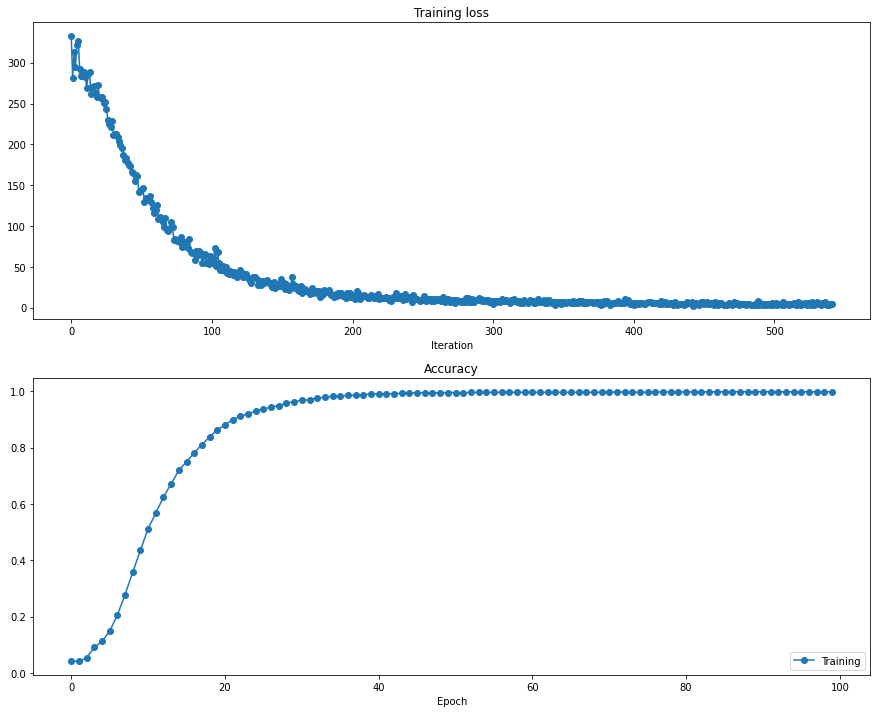

In [25]:
%reload_ext autoreload

opt_params, loss_hist, train_acc_hist = results

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

Now you can generate text using the trained model. You can start from a specific word in the original text, such as `she`. (We expect the text to not be too repetitive, i.e. not repeating the same three words over and over. See an example of an acceptable sample below.)

> she was dozing off, and book-shelves; here and she tried to curtsey as she spoke--fancy curtseying as you’re falling through the little door into a dreamy sort of way, ‘do cats eat bats? do cats eat bats?’ and sometimes,

In [26]:
%reload_ext autoreload

# you can change the generated text length below.
text_length = 40

idx = 0
# you also can start from specific word. 
# since the words are all converted into lower case
idx = int(np.where(np.asarray(word_list) == 'She'.lower())[0])

# sample from the trained model
words = model.sample(idx, text_length-1)

# convert indices into words
output = [word_list[i] for i in words]
print(' '.join(output))

she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking


### Inline Question (2 Pts): Play around with different settings to get better understanding of its behavior and describe your observation. Make sure to cover at least the following points:
* Vanilla RNN vs LSTM (you can set different training timesteps `T` and `test_length` to test with longer texts.)
* Limitations you observed when training the recurrent language models. What could be causing them? (there's no unique answer. just explain your own opinion from experiments.)

(Please limit your answer to <150 words)

#### Ans: In case of RNN, as we keep write the information to the cell, and as the Time periods increase, we will be morphing the information used at the early stages. And then, there is also problem of Vanishing and exploding gradients. LSTM helps us with respective to vanishing gradients using selective read,  write and forget through Gates. 
#### Limitations : The context is properly preserved in a sentence, but context between sentences has no meaning. Adding to that, the challenge was Selection of parameters like batchsize. Like, what is good batch size is difficult to decide, and that can largely impact the output we get. 

# Submission

Please prepare a PDF document `problem_2_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for vanilla RNN and LSTM training
2. Sample text generation from a trained model
3. Answers to inline questions about recurrent net behavior

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.

# More Text Corpora (Not Graded)
If you want to explore the capabilities of your model further, feel free to train the model on new text corpora! Just bring them in the appropriate format (see above) and then train your model. You can change any of the hyperparameters in the code blocks below. If your model produces some fun outputs you can print them below (including the text corpus the model was trained on).

**! Note that this is completely optional and has no influence on the grade of the assignment. !**

**! Please make sure that all notebook blocks above show results trained on the original text dataset for the assignment as we can only grade those. !**

In [74]:
%reload_ext autoreload

################ LOAD YOUR DATA HERE ####################
# word_list: list of unique vocabulary entries, e.g. ['', 'country', 'slippery;', 'hurt,', 'long', ...]
text = ['the', 'central', 'character', 'in', 'the', 'series', 'is', 'harry', 'potter,', 'a', 'boy', 'who', 'lives', 'in', 'the', 'fictional', 'town', 'of', 'little', 'whinging,', 'surrey', 'with', 'his', 'aunt,', 'uncle,', 'and', 'cousin', '–', 'the', 'dursleys', '–', 'and', 'discovers', 'at', 'the', 'age', 'of', 'eleven', 'that', 'he', 'is', 'a', 'wizard,', 'though', 'he', 'lives', 'in', 'the', 'ordinary', 'world', 'of', 'non-magical', 'people', 'known', 'as', 'muggles.[8]', 'the', 'wizarding', 'world', 'exists', 'parallel', 'to', 'the', 'muggle', 'world,', 'albeit', 'hidden', 'and', 'in', 'secrecy.', 'his', 'magical', 'ability', 'is', 'inborn,', 'and', 'children', 'with', 'such', 'abilities', 'are', 'invited', 'to', 'attend', 'exclusive', 'magic', 'schools', 'that', 'teach', 'the', 'necessary', 'skills', 'to', 'succeed', 'in', 'the', 'wizarding', 'world.[9]', 'harry', 'becomes', 'a', 'student', 'at', 'hogwarts', 'school', 'of', 'witchcraft', 'and', 'wizardry,', 'a', 'wizarding', 'academy', 'in', 'scotland,', 'and', 'it', 'is', 'here', 'where', 'most', 'of', 'the', 'events', 'in', 'the', 'series', 'take', 'place.', 'as', 'harry', 'develops', 'through', 'his', 'adolescence,', 'he', 'learns', 'to', 'overcome', 'the', 'problems', 'that', 'face', 'him:', 'magical,', 'social,', 'and', 'emotional,', 'including', 'ordinary', 'teenage', 'challenges', 'such', 'as', 'friendships,', 'infatuation,', 'romantic', 'relationships,', 'schoolwork', 'and', 'exams,', 'anxiety,', 'depression,', 'stress,', 'and', 'the', 'greater', 'test', 'of', 'preparing', 'himself', 'for', 'the', 'confrontation', 'that', 'lies', 'ahead', 'in', 'wizarding', "britain's", 'increasingly-violent', 'second', 'wizarding', 'war.[10]', 'each', 'novel', 'chronicles', 'one', 'year', 'in', "harry's", 'life[11]', 'during', 'the', 'period', 'from', '1991', 'to', '1998.[12]', 'the', 'books', 'also', 'contain', 'many', 'flashbacks,', 'which', 'are', 'frequently', 'experienced', 'by', 'harry', 'viewing', 'the', 'memories', 'of', 'other', 'characters', 'in', 'a', 'device', 'called', 'a', 'pensieve.', 'the', 'environment', 'rowling', 'created', 'is', 'intimately', 'connected', 'to', 'reality.', 'the', 'british', 'magical', 'community', 'of', 'the', 'harry', 'potter', 'books', 'is', 'inspired', 'by', '1990s', 'british', 'culture,', 'european', 'folklore,', 'classical', 'mythology', 'and', 'alchemy,', 'incorporating', 'objects', 'and', 'wildlife', 'such', 'as', 'magic', 'wands,', 'magic', 'plants,', 'potions,', 'spells,', 'flying', 'broomsticks,', 'centaurs', 'and', 'other', 'magical', 'creatures,', 'and', 'the', "philosopher's", 'stone,', 'beside', 'others', 'invented', 'by', 'rowling.', 'while', 'the', 'fantasy', 'land', 'of', 'narnia', 'is', 'an', 'alternate', 'universe', 'and', 'the', 'lord', 'of', 'the', "rings'", 'middle-earth', 'a', 'mythic', 'past,', 'the', 'wizarding', 'world', 'of', 'harry', 'potter', 'exists', 'parallel', 'to', 'the', 'real', 'world', 'and', 'contains', 'magical', 'versions', 'of', 'the', 'ordinary', 'elements', 'of', 'everyday', 'life,', 'with', 'the', 'action', 'mostly', 'set', 'in', 'scotland', '(hogwarts),', 'the', 'west', 'country,', 'devon,', 'london,', 'and', 'surrey', 'in', 'southeast', 'england.[13]', 'the', 'world', 'only', 'accessible', 'to', 'wizards', 'and', 'magical', 'beings', 'comprises', 'a', 'fragmented', 'collection', 'of', 'overlooked', 'hidden', 'streets,', 'ancient', 'pubs,', 'lonely', 'country', 'manors,', 'and', 'secluded', 'castles', 'invisible', 'to', 'the', 'muggle', 'population.[9]', 'early', 'years.', 'when', 'the', 'first', 'novel', 'of', 'the', 'series,', 'harry', 'potter', 'and', 'the', "philosopher's", 'stone,', 'opens,', 'it', 'is', 'apparent', 'that', 'some', 'significant', 'event', 'has', 'taken', 'place', 'in', 'the', 'wizarding', 'world', '–', 'an', 'event', 'so', 'very', 'remarkable', 'that', 'even', 'muggles', '(non-magical', 'people)', 'notice', 'signs', 'of', 'it.', 'the', 'full', 'background', 'to', 'this', 'event', 'and', 'harry', "potter's", 'past', 'is', 'revealed', 'gradually', 'throughout', 'the', 'series.', 'after', 'the', 'introductory', 'chapter,', 'the', 'book', 'leaps', 'forward', 'to', 'a', 'time', 'shortly', 'before', 'harry', "potter's", 'eleventh', 'birthday,', 'and', 'it', 'is', 'at', 'this', 'point', 'that', 'his', 'magical', 'background', 'begins', 'to', 'be', 'revealed.', 'despite', "harry's", 'aunt', 'and', "uncle's", 'desperate', 'prevention', 'of', 'harry', 'learning', 'about', 'his', 'abilities,[14]', 'their', 'efforts', 'are', 'in', 'vain.', 'harry', 'meets', 'a', 'half-giant,', 'rubeus', 'hagrid,', 'who', 'is', 'also', 'his', 'first', 'contact', 'with', 'the', 'wizarding', 'world.', 'hagrid', 'reveals', 'himself', 'to', 'be', 'the', 'keeper', 'of', 'keys', 'and', 'grounds', 'at', 'hogwarts', 'as', 'well', 'as', 'some', 'of', "harry's", 'history.[14]', 'harry', 'learns', 'that,', 'as', 'a', 'baby,', 'he', 'witnessed', 'his', "parents'", 'murder', 'by', 'the', 'power-obsessed', 'dark', 'wizard', 'lord', 'voldemort,', 'who', 'subsequently', 'attempted', 'to', 'kill', 'him', 'as', 'well.[14]', 'instead,', 'the', 'unexpected', 'happened:', 'harry', 'survived', 'with', 'only', 'a', 'lightning-shaped', 'scar', 'on', 'his', 'forehead', 'as', 'a', 'memento', 'of', 'the', 'attack,', 'and', 'voldemort', 'disappeared', 'soon', 'afterwards,', 'gravely', 'weakened', 'by', 'his', 'own', 'rebounding', 'curse.', 'as', 'its', 'inadvertent', 'saviour', 'from', "voldemort's", 'reign', 'of', 'terror,', 'harry', 'has', 'become', 'a', 'living', 'legend', 'in', 'the', 'wizarding', 'world.', 'however,', 'at', 'the', 'orders', 'of', 'the', 'venerable', 'and', 'well-known', 'wizard', 'albus', 'dumbledore,', 'the', 'orphaned', 'harry', 'had', 'been', 'placed', 'in', 'the', 'home', 'of', 'his', 'unpleasant', 'muggle', 'relatives,', 'the', 'dursleys,', 'who', 'have', 'kept', 'him', 'safe', 'but', 'treated', 'him', 'poorly,', 'including', 'confining', 'him', 'to', 'a', 'cupboard', 'without', 'meals', 'and', 'treating', 'him', 'as', 'their', 'servant.', 'hagrid', 'then', 'officially', 'invites', 'harry', 'to', 'attend', 'hogwarts', 'school', 'of', 'witchcraft', 'and', 'wizardry,', 'a', 'famous', 'magic', 'school', 'in', 'scotland', 'that', 'educates', 'young', 'teenagers', 'on', 'their', 'magical', 'development', 'for', 'seven', 'years,', 'from', 'age', 'eleven', 'to', 'seventeen.', 'with', "hagrid's", 'help,', 'harry', 'prepares', 'for', 'and', 'undertakes', 'his', 'first', 'year', 'of', 'study', 'at', 'hogwarts.', 'as', 'harry', 'begins', 'to', 'explore', 'the', 'magical', 'world,', 'the', 'reader', 'is', 'introduced', 'to', 'many', 'of', 'the', 'primary', 'locations', 'used', 'throughout', 'the', 'series.', 'harry', 'meets', 'most', 'of', 'the', 'main', 'characters', 'and', 'gains', 'his', 'two', 'closest', 'friends:', 'ron', 'weasley,', 'a', 'fun-loving', 'member', 'of', 'an', 'ancient,', 'large,', 'happy,', 'but', 'poor', 'wizarding', 'family,', 'and', 'hermione', 'granger,', 'a', 'gifted,', 'bright,', 'and', 'hardworking', 'witch', 'of', 'non-magical', 'parentage.[14][15]', 'harry', 'also', 'encounters', 'the', "school's", 'potions', 'master,', 'severus', 'snape,', 'who', 'displays', 'a', 'conspicuously', 'deep', 'and', 'abiding', 'dislike', 'for', 'him,', 'the', 'rich', 'brat', 'draco', 'malfoy', 'whom', 'he', 'quickly', 'makes', 'enemies', 'with,', 'and', 'the', 'defence', 'against', 'the', 'dark', 'arts', 'teacher,', 'quirinus', 'quirrell,', 'who', 'later', 'turns', 'out', 'to', 'be', 'allied', 'with', 'lord', 'voldemort.', 'he', 'also', 'discovers', 'a', 'talent', 'of', 'flying', 'on', 'broomsticks', 'and', 'is', 'recruited', 'for', 'his', "house's", 'quidditch', 'team,', 'a', 'sport', 'in', 'the', 'wizarding', 'world', 'where', 'players', 'fly', 'on', 'broomsticks.', 'the', 'first', 'book', 'concludes', 'with', "harry's", 'second', 'confrontation', 'with', 'lord', 'voldemort,', 'who,', 'in', 'his', 'quest', 'to', 'regain', 'a', 'body,', 'yearns', 'to', 'gain', 'the', 'power', 'of', 'the', "philosopher's", 'stone,', 'a', 'substance', 'that', 'bestows', 'everlasting', 'life', 'and', 'turns', 'any', 'metal', 'into', 'pure', 'gold.[14]', 'the', 'series', 'continues', 'with', 'harry', 'potter', 'and', 'the', 'chamber', 'of', 'secrets,', 'describing', "harry's", 'second', 'year', 'at', 'hogwarts.', 'he', 'and', 'his', 'friends', 'investigate', 'a', '50-year-old', 'mystery', 'that', 'appears', 'uncannily', 'related', 'to', 'recent', 'sinister', 'events', 'at', 'the', 'school.', "ron's", 'younger', 'sister,', 'ginny', 'weasley,', 'enrolls', 'in', 'her', 'first', 'year', 'at', 'hogwarts,', 'and', 'finds', 'an', 'old', 'notebook', 'in', 'her', 'belongings', 'which', 'turns', 'out', 'to', 'be', 'the', 'diary', 'of', 'a', 'previous', 'student,', 'tom', 'marvolo', 'riddle,', 'later', 'revealed', 'to', 'be', "voldemort's", 'younger', 'self,', 'who', 'is', 'bent', 'on', 'ridding', 'the', 'school', 'of', '"mudbloods",', 'a', 'derogatory', 'term', 'describing', 'wizards', 'and', 'witches', 'of', 'non-magical', 'parentage.', 'the', 'memory', 'of', 'tom', 'riddle', 'resides', 'inside', 'of', 'the', 'diary', 'and', 'when', 'ginny', 'begins', 'to', 'confide', 'in', 'the', 'diary,', 'voldemort', 'is', 'able', 'to', 'possess', 'her.', 'through', 'the', 'diary,', 'ginny', 'acts', 'on', "voldemort's", 'orders', 'and', 'unconsciously', 'opens', 'the', '"chamber', 'of', 'secrets",', 'unleashing', 'an', 'ancient', 'monster,', 'later', 'revealed', 'to', 'be', 'a', 'basilisk,', 'which', 'begins', 'attacking', 'students', 'at', 'hogwarts.', 'it', 'kills', 'those', 'who', 'make', 'direct', 'eye', 'contact', 'with', 'it', 'and', 'petrifies', 'those', 'who', 'look', 'at', 'it', 'indirectly.', 'the', 'book', 'also', 'introduces', 'a', 'new', 'defence', 'against', 'the', 'dark', 'arts', 'teacher,', 'gilderoy', 'lockhart,', 'a', 'highly', 'cheerful,', 'self-conceited', 'wizard', 'with', 'a', 'pretentious', 'facade,', 'later', 'turning', 'out', 'to', 'be', 'a', 'fraud.', 'harry', 'discovers', 'that', 'prejudice', 'exists', 'in', 'the', 'wizarding', 'world', 'through', 'delving', 'into', 'the', "school's", 'history,', 'and', 'learns', 'that', "voldemort's", 'reign', 'of', 'terror', 'was', 'often', 'directed', 'at', 'wizards', 'and', 'witches', 'who', 'were', 'descended', 'from', 'muggles.', 'harry', 'also', 'learns', 'that', 'his', 'ability', 'to', 'speak', 'the', 'snake', 'language', 'parseltongue', 'is', 'rare', 'and', 'often', 'associated', 'with', 'the', 'dark', 'arts.', 'when', 'hermione', 'is', 'attacked', 'and', 'petrified,', 'harry', 'and', 'ron', 'finally', 'piece', 'together', 'the', 'puzzles', 'and', 'unlock', 'the', 'chamber', 'of', 'secrets,', 'with', 'harry', 'destroying', 'the', 'diary', 'for', 'good', 'and', 'saving', 'ginny,', 'and,', 'as', 'they', 'learn', 'later,', 'also', 'destroying', 'a', 'part', 'of', "voldemort's", 'soul.', 'the', 'end', 'of', 'the', 'book', 'reveals', 'lucius', 'malfoy,', "draco's", 'father', 'and', 'rival', 'of', 'ron', 'and', "ginny's", 'father,', 'to', 'be', 'the', 'culprit', 'who', 'slipped', 'the', 'book', 'into', "ginny's", 'belongings.', 'the', 'third', 'novel,', 'harry', 'potter', 'and', 'the', 'prisoner', 'of', 'azkaban,', 'follows', 'harry', 'in', 'his', 'third', 'year', 'of', 'magical', 'education.', 'it', 'is', 'the', 'only', 'book', 'in', 'the', 'series', 'which', 'does', 'not', 'feature', 'lord', 'voldemort', 'in', 'any', 'form,', 'only', 'being', 'mentioned.', 'instead,', 'harry', 'must', 'deal', 'with', 'the', 'knowledge', 'that', 'he', 'has', 'been', 'targeted', 'by', 'sirius', 'black,', 'his', "father's", 'best', 'friend,', 'and,', 'according', 'to', 'the', 'wizarding', 'world,', 'an', 'escaped', 'mass', 'murderer', 'who', 'assisted', 'in', 'the', 'murder', 'of', "harry's", 'parents.', 'as', 'harry', 'struggles', 'with', 'his', 'reaction', 'to', 'the', 'dementors', '–', 'dark', 'creatures', 'with', 'the', 'power', 'to', 'devour', 'a', 'human', 'soul', 'and', 'feed', 'on', 'despair', '–', 'which', 'are', 'ostensibly', 'protecting', 'the', 'school,', 'he', 'reaches', 'out', 'to', 'remus', 'lupin,', 'a', 'defence', 'against', 'the', 'dark', 'arts', 'teacher', 'who', 'is', 'eventually', 'revealed', 'to', 'be', 'a', 'werewolf.', 'lupin', 'teaches', 'harry', 'defensive', 'measures', 'which', 'are', 'well', 'above', 'the', 'level', 'of', 'magic', 'generally', 'executed', 'by', 'people', 'his', 'age.', 'harry', 'comes', 'to', 'know', 'that', 'both', 'lupin', 'and', 'black', 'were', 'best', 'friends', 'of', 'his', 'father', 'and', 'that', 'black', 'was', 'framed', 'by', 'their', 'fourth', 'friend,', 'peter', 'pettigrew,', 'who', 'had', 'been', 'hiding', 'as', "ron's", 'pet', 'rat,', 'scabbers.[16]', 'in', 'this', 'book,', 'a', 'recurring', 'theme', 'throughout', 'the', 'series', 'is', 'emphasised', '–', 'in', 'every', 'book', 'there', 'is', 'a', 'new', 'defence', 'against', 'the', 'dark', 'arts', 'teacher,', 'none', 'of', 'whom', 'lasts', 'more', 'than', 'one', 'school', 'year.', 'voldemort', 'returns.in', '1996,', 'treasure', 'hunter', 'brock', 'lovett', 'and', 'his', 'team', 'board', 'the', 'research', 'vessel', 'akademik', 'mstislav', 'keldysh', 'to', 'search', 'the', 'wreck', 'of', 'rms', 'titanic', 'for', 'a', 'necklace', 'with', 'a', 'rare', 'diamond,', 'the', 'heart', 'of', 'the', 'ocean.', 'they', 'recover', 'a', 'safe', 'containing', 'a', 'drawing', 'of', 'a', 'young', 'woman', 'wearing', 'only', 'the', 'necklace', 'dated', 'april', '14,', '1912,', 'the', 'day', 'the', 'ship', 'struck', 'the', 'iceberg.[note', '1]', 'rose', 'dawson', 'calvert,', 'the', 'woman', 'in', 'the', 'drawing,', 'is', 'brought', 'aboard', 'keldysh', 'and', 'tells', 'lovett', 'of', 'her', 'experiences', 'aboard', 'titanic.', 'in', '1912', 'southampton,', '17-year-old', 'first-class', 'passenger', 'rose', 'dewitt', 'bukater,', 'her', 'fiancé', 'cal', 'hockley,', 'and', 'her', 'mother', 'ruth', 'board', 'the', 'luxurious', 'titanic.', 'ruth', 'emphasizes', 'that', "rose's", 'marriage', 'will', 'resolve', 'their', "family's", 'financial', 'problems', 'and', 'allow', 'them', 'to', 'retain', 'their', 'upper-class', 'status.', 'distraught', 'over', 'the', 'engagement,', 'rose', 'climbs', 'over', 'the', 'stern', 'and', 'contemplates', 'suicide;', 'jack', 'dawson,', 'a', 'poor', 'artist,', 'intervenes', 'and', 'discourages', 'her.', 'discovered', 'with', 'jack,', 'rose', 'tells', 'a', 'concerned', 'cal', 'that', 'she', 'was', 'peering', 'over', 'the', 'edge', 'and', 'jack', 'saved', 'her', 'from', 'falling.', 'cal', 'becomes', 'indifferent,', 'and', 'it', 'is', 'suggested', 'to', 'him', 'that', 'jack', 'be', 'rewarded;', 'he', 'invites', 'jack', 'to', 'dine', 'with', 'them', 'in', 'first-class.', 'jack', 'and', 'rose', 'develop', 'a', 'tentative', 'friendship,', 'despite', 'cal,', 'his', 'valet', 'spicer', 'lovejoy,', 'and', 'ruth,', 'being', 'wary', 'of', 'him.', 'following', 'dinner,', 'rose', 'secretly', 'joins', 'jack', 'at', 'a', 'party', 'in', 'third-class.', 'aware', 'of', 'cal', 'and', "ruth's", 'disapproval,', 'rose', 'rebuffs', "jack's", 'advances,', 'but', 'later', 'realizes', 'she', 'prefers', 'him', 'over', 'cal.', 'after', 'rendezvousing', 'on', 'the', 'bow', 'at', 'sunset,', 'rose', 'takes', 'jack', 'to', 'her', 'state', 'room;', 'at', 'her', 'request,', 'jack', 'sketches', 'rose', 'posing', 'nude', 'wearing', "cal's", 'engagement', 'present,', 'the', 'heart', 'of', 'the', 'ocean.', 'they', 'evade', 'lovejoy,', 'and', 'have', 'sex', 'in', 'an', 'automobile', 'inside', 'the', 'cargo', 'hold.', 'on', 'the', 'forward', 'deck,', 'they', 'witness', 'the', "ship's", 'collision', 'with', 'an', 'iceberg', 'and', 'overhear', 'its', 'officers', 'and', 'builder', 'discussing', 'its', 'seriousness.', 'cal', 'discovers', "jack's", 'sketch', 'of', 'rose', 'and', 'an', 'insulting', 'note', 'from', 'her', 'in', 'his', 'safe', 'along', 'with', 'the', 'necklace.', 'when', 'jack', 'and', 'rose', 'attempt', 'to', 'inform', 'cal', 'of', 'the', 'collision,', 'cal', 'retaliates', 'by', 'having', 'lovejoy', 'slip', 'the', 'necklace', 'into', "jack's", 'pocket,', 'accusing', 'him', 'of', 'theft.', 'jack', 'is', 'arrested', 'and', 'restrained', 'in', 'the', "master-at-arms'", 'office.', 'cal', 'puts', 'the', 'necklace', 'in', 'his', 'own', 'coat', 'pocket.', 'with', 'the', 'ship', 'sinking,', 'rose', 'flees', 'cal', 'and', 'her', 'mother,', 'who', 'has', 'boarded', 'a', 'lifeboat,', 'and', 'frees', 'jack.', 'on', 'the', 'boat', 'deck,', 'cal', 'and', 'jack', 'encourage', 'her', 'to', 'board', 'a', 'lifeboat.', 'while', 'intending', 'only', 'to', 'save', 'himself,', 'cal', 'claims', 'he', 'can', 'ensure', 'he', 'and', 'jack', 'get', 'off', 'safely.', 'as', 'her', 'lifeboat', 'lowers,', 'rose', 'realizes', 'she', 'cannot', 'leave', 'jack,', 'and', 'jumps', 'back', 'on', 'board.', 'cal', 'takes', "lovejoy's", 'pistol', 'and', 'chases', 'rose', 'and', 'jack', 'into', 'the', 'flooding', 'first-class', 'dining', 'saloon.', 'after', 'using', 'up', 'his', 'ammunition,', 'he', 'relents.', 'cal', 'realizes', 'he', 'gave', 'his', 'coat,', 'and', 'consequently', 'the', 'necklace,', 'to', 'rose.', 'he', 'later', 'boards', 'a', 'lifeboat', 'by', 'carrying', 'a', 'lost', 'child.', 'after', 'braving', 'several', 'obstacles,', 'jack', 'and', 'rose', 'return', 'to', 'the', 'boat', 'deck.', 'the', 'lifeboats', 'have', 'departed', 'and', 'passengers', 'are', 'falling', 'to', 'their', 'deaths', 'as', 'the', 'stern', 'rises', 'out', 'of', 'the', 'water.', 'the', 'ship', 'breaks', 'in', 'half,', 'dropping', 'the', 'stern', 'into', 'the', 'water.', 'jack', 'and', 'rose', 'climb', 'onto', 'the', 'back', 'of', 'it,', 'and', 'ride', 'it', 'into', 'the', 'ocean.', 'he', 'helps', 'her', 'onto', 'a', 'wooden', 'panel', 'buoyant', 'enough', 'for', 'only', 'one', 'person.', 'he', 'assures', 'her', 'that', 'she', 'will', 'die', 'an', 'old', 'woman,', 'warm', 'in', 'her', 'bed.', 'jack', 'dies', 'of', 'hypothermia,[8]', 'but', 'rose', 'is', 'saved', 'by', 'a', 'returning', 'lifeboat.', 'the', 'rms', 'carpathia', 'later', 'rescues', 'the', 'survivors;', 'on', 'board,', 'rose', 'hides', 'from', 'cal', 'en', 'route', 'to', 'new', 'york', 'city,', 'where', 'she', 'gives', 'her', 'name', 'as', 'rose', 'dawson.', 'rose', 'says', 'she', 'later', 'read', 'that', 'cal', 'committed', 'suicide', 'due', 'to', 'financial', 'hardship', 'as', 'a', 'result', 'of', 'the', 'wall', 'street', 'crash', 'of', '1929.', 'back', 'in', 'the', 'present,', 'lovett', 'decides', 'to', 'abandon', 'his', 'search', 'after', 'hearing', "rose's", 'story.', 'alone', 'on', 'the', 'stern', 'of', 'keldysh,', 'rose', 'takes', 'out', 'the', 'heart', 'of', 'the', 'ocean,', 'which', 'was', 'in', 'her', 'possession', 'all', 'along,', 'and', 'drops', 'it', 'into', 'the', 'sea', 'over', 'the', 'wreck', 'site.', 'while', 'she', 'is', 'seemingly', 'asleep', 'or', 'has', 'died', 'in', 'her', 'bed,[9]', 'photos', 'on', 'her', 'dresser', 'depict', 'a', 'life', 'of', 'freedom', 'and', 'adventure.', 'a', 'young', 'rose', 'reunites', 'with', 'jack', 'at', "titanic's", 'grand', 'staircase,', 'applauded', 'by', 'those', 'who', 'died', 'on', 'the', 'ship.', '"the', 'elephant', 'house",', 'a', 'small,', 'painted', 'red', 'café', 'where', 'rowling', 'wrote', 'a', 'few', 'chapters', 'of', 'harry', 'potter', 'and', 'the', "philosopher's", 'stone', 'the', 'elephant', 'house', 'was', 'one', 'of', 'the', 'cafés', 'in', 'edinburgh', 'where', 'rowling', 'wrote', 'the', 'first', 'part', 'of', 'harry', 'potter.', 'the', 'former', '1st', 'floor', "nicholson's", 'cafe', 'now', 'renamed', 'spoon', 'in', 'edinburgh', 'where', 'j.', 'k.', 'rowling', 'wrote', 'the', 'first', 'few', 'chapters', 'of', 'harry', 'potter', 'and', 'the', 'philosopher’s', 'stone.', 'the', 'j.', 'k.', 'rowling', 'plaque', 'on', 'the', 'corner', 'of', 'the', 'former', "nicholson's", 'cafe', '(now', 'renamed', 'spoon)', 'at', '6a', 'nicolson', 'st,', 'edinburgh.', 'during', "harry's", 'fourth', 'year', 'of', 'school', '(detailed', 'in', 'harry', 'potter', 'and', 'the', 'goblet', 'of', 'fire),', 'harry', 'is', 'unwillingly', 'entered', 'as', 'a', 'participant', 'in', 'the', 'triwizard', 'tournament,', 'a', 'dangerous', 'yet', 'exciting', 'contest', 'where', 'three', '"champions",', 'one', 'from', 'each', 'participating', 'school,', 'must', 'compete', 'with', 'each', 'other', 'in', 'three', 'tasks', 'in', 'order', 'to', 'win', 'the', 'triwizard', 'cup.', 'this', 'year,', 'harry', 'must', 'compete', 'against', 'a', 'witch', 'and', 'a', 'wizard', '"champion"', 'from', 'overseas', 'schools', 'beauxbatons', 'and', 'durmstrang,', 'as', 'well', 'as', 'another', 'hogwarts', 'student,', 'causing', "harry's", 'friends', 'to', 'distance', 'themselves', 'from', 'him.[17]', 'harry', 'is', 'guided', 'through', 'the', 'tournament', 'by', 'their', 'new', 'defence', 'against', 'the', 'dark', 'arts', 'professor,', 'alastor', '"mad-eye"', 'moody,', 'who', 'turns', 'out', 'to', 'be', 'an', 'impostor', '–', 'one', 'of', "voldemort's", 'supporters', 'named', 'barty', 'crouch,', 'jr.', 'in', 'disguise,', 'who', 'secretly', 'entered', "harry's", 'name', 'into', 'the', 'tournament.', 'the', 'point', 'at', 'which', 'the', 'mystery', 'is', 'unravelled', 'marks', 'the', "series'", 'shift', 'from', 'foreboding', 'and', 'uncertainty', 'into', 'open', 'conflict.', "voldemort's", 'plan', 'to', 'have', 'crouch', 'use', 'the', 'tournament', 'to', 'bring', 'harry', 'to', 'voldemort', 'succeeds.', 'although', 'harry', 'manages', 'to', 'escape,', 'cedric', 'diggory,', 'the', 'other', 'hogwarts', 'champion', 'in', 'the', 'tournament,', 'is', 'killed', 'by', 'peter', 'pettigrew', 'and', 'voldemort', 're-enters', 'the', 'wizarding', 'world', 'with', 'a', 'physical', 'body.', 'in', 'the', 'fifth', 'book,', 'harry', 'potter', 'and', 'the', 'order', 'of', 'the', 'phoenix,', 'harry', 'must', 'confront', 'the', 'newly', 'resurfaced', 'voldemort.', 'in', 'response', 'to', "voldemort's", 'reappearance,', 'dumbledore', 're-activates', 'the', 'order', 'of', 'the', 'phoenix,', 'a', 'secret', 'society', 'which', 'works', 'from', 'sirius', "black's", 'dark', 'family', 'home', 'to', 'defeat', "voldemort's", 'minions', 'and', 'protect', "voldemort's", 'targets,', 'especially', 'harry.', 'despite', "harry's", 'description', 'of', "voldemort's", 'recent', 'activities,', 'the', 'ministry', 'of', 'magic', 'and', 'many', 'others', 'in', 'the', 'magical', 'world', 'refuse', 'to', 'believe', 'that', 'voldemort', 'has', 'returned.', 'in', 'an', 'attempt', 'to', 'counter', 'and', 'eventually', 'discredit', 'dumbledore,', 'who', 'along', 'with', 'harry', 'is', 'the', 'most', 'prominent', 'voice', 'in', 'the', 'wizarding', 'world', 'attempting', 'to', 'warn', 'of', "voldemort's", 'return,', 'the', 'ministry', 'appoints', 'dolores', 'umbridge', 'as', 'the', 'high', 'inquisitor', 'of', 'hogwarts', 'and', 'the', 'new', 'defence', 'against', 'the', 'dark', 'arts', 'teacher.', 'she', 'transforms', 'the', 'school', 'into', 'a', 'dictatorial', 'regime', 'and', 'refuses', 'to', 'allow', 'the', 'students', 'to', 'learn', 'ways', 'to', 'defend', 'themselves', 'against', 'dark', 'magic.[18]', 'hermione', 'and', 'ron', 'form', '"dumbledore\'s', 'army",', 'a', 'secret', 'study', 'group', 'in', 'which', 'harry', 'agrees', 'to', 'teach', 'his', 'classmates', 'the', 'higher-level', 'skills', 'of', 'defence', 'against', 'the', 'dark', 'arts', 'that', 'he', 'has', 'learned', 'from', 'his', 'previous', 'encounters', 'with', 'dark', 'wizards.', 'through', 'those', 'lessons,', 'harry', 'begins', 'to', 'develop', 'a', 'crush', 'on', 'the', 'popular', 'and', 'attractive', 'cho', 'chang.', 'juggling', 'schoolwork,', "umbridge's", 'incessant', 'and', 'persistent', 'efforts', 'to', 'land', 'him', 'in', 'trouble', 'and', 'the', 'defensive', 'lessons,', 'harry', 'begins', 'to', 'lose', 'sleep', 'as', 'he', 'constantly', 'receives', 'disturbing', 'dreams', 'about', 'a', 'dark', 'corridor', 'in', 'the', 'ministry', 'of', 'magic,', 'followed', 'by', 'a', 'burning', 'desire', 'to', 'learn', 'more.', 'an', 'important', 'prophecy', 'concerning', 'harry', 'and', 'lord', 'voldemort', 'is', 'then', 'revealed,[19]', 'and', 'harry', 'discovers', 'that', 'he', 'and', 'voldemort', 'have', 'a', 'painful', 'connection,', 'allowing', 'harry', 'to', 'view', 'some', 'of', "voldemort's", 'actions', 'telepathically.', 'in', 'the', "novel's", 'climax,', 'harry', 'is', 'tricked', 'into', 'seeing', 'sirius', 'tortured', 'and', 'races', 'to', 'the', 'ministry', 'of', 'magic.', 'he', 'and', 'his', 'friends', 'face', 'off', 'against', "voldemort's", 'followers', '(nicknamed', 'death', 'eaters)', 'at', 'the', 'ministry', 'of', 'magic.', 'although', 'the', 'timely', 'arrival', 'of', 'members', 'of', 'the', 'order', 'of', 'the', 'phoenix', 'saves', 'the', "teenagers'", 'lives,', 'sirius', 'black', 'is', 'killed', 'in', 'the', 'conflict.', 'in', 'the', 'sixth', 'book,', 'harry', 'potter', 'and', 'the', 'half-blood', 'prince,', 'voldemort', 'begins', 'waging', 'open', 'warfare.', 'harry', 'and', 'his', 'friends', 'are', 'relatively', 'protected', 'from', 'that', 'danger', 'at', 'hogwarts.', 'they', 'are', 'subject', 'to', 'all', 'the', 'difficulties', 'of', 'adolescence', '–', 'harry', 'eventually', 'begins', 'dating', 'ginny,', 'ron', 'establishes', 'a', 'strong', 'infatuation', 'with', 'fellow', 'hogwarts', 'student', 'lavender', 'brown,', 'and', 'hermione', 'starts', 'to', 'develop', 'romantic', 'feelings', 'towards', 'ron.', 'near', 'the', 'beginning', 'of', 'the', 'novel,', 'lacking', 'his', 'own', 'book,', 'harry', 'is', 'given', 'an', 'old', 'potions', 'textbook', 'filled', 'with', 'many', 'annotations', 'and', 'recommendations', 'signed', 'by', 'a', 'mysterious', 'writer', 'titled;', '"the', 'half-blood', 'prince".', 'this', 'book', 'is', 'a', 'source', 'of', 'scholastic', 'success', 'and', 'great', 'recognition', 'from', 'their', 'new', 'potions', 'master,', 'horace', 'slughorn,', 'but', 'because', 'of', 'the', 'potency', 'of', 'the', 'spells', 'that', 'are', 'written', 'in', 'it,', 'becomes', 'a', 'source', 'of', 'concern.', 'with', 'war', 'drawing', 'near,', 'harry', 'takes', 'private', 'lessons', 'with', 'dumbledore,', 'who', 'shows', 'him', 'various', 'memories', 'concerning', 'the', 'early', 'life', 'of', 'voldemort', 'in', 'a', 'device', 'called', 'a', 'pensieve.', 'these', 'reveal', 'that', 'in', 'order', 'to', 'preserve', 'his', 'life,', 'voldemort', 'has', 'split', 'his', 'soul', 'into', 'pieces,', 'used', 'to', 'create', 'a', 'series', 'of', 'horcruxes', '–', 'evil', 'enchanted', 'items', 'hidden', 'in', 'various', 'locations,', 'one', 'of', 'which', 'was', 'the', 'diary', 'destroyed', 'in', 'the', 'second', 'book.[20]', 'draco,', 'who', 'has', 'joined', 'with', 'the', 'death', 'eaters,', 'attempts', 'to', 'attack', 'dumbledore', 'upon', 'his', 'return', 'from', 'collecting', 'a', 'horcrux,', 'and', 'the', 'book', 'culminates', 'in', 'the', 'killing', 'of', 'dumbledore', 'by', 'professor', 'snape,', 'the', 'titular', 'half-blood', 'prince.', 'harry', 'potter', 'and', 'the', 'deathly', 'hallows,', 'the', 'last', 'original', 'novel', 'in', 'the', 'series,', 'begins', 'directly', 'after', 'the', 'events', 'of', 'the', 'sixth', 'book.', 'lord', 'voldemort', 'has', 'completed', 'his', 'ascension', 'to', 'power', 'and', 'gained', 'control', 'of', 'the', 'ministry', 'of', 'magic.', 'harry,', 'ron', 'and', 'hermione', 'drop', 'out', 'of', 'school', 'so', 'that', 'they', 'can', 'find', 'and', 'destroy', "voldemort's", 'remaining', 'horcruxes.', 'to', 'ensure', 'their', 'own', 'safety', 'as', 'well', 'as', 'that', 'of', 'their', 'family', 'and', 'friends,', 'they', 'are', 'forced', 'to', 'isolate', 'themselves.', 'a', 'ghoul', 'pretends', 'to', 'be', 'ron', 'ill', 'with', 'a', 'contagious', 'disease,', 'harry', 'and', 'the', 'dursleys', 'separate,', 'and', 'hermione', 'wipes', 'her', "parents'", 'memories', 'and', 'sends', 'them', 'abroad.', 'as', 'the', 'trio', 'searches', 'for', 'the', 'horcruxes,', 'they', 'learn', 'details', 'about', 'an', 'ancient', 'prophecy', 'of', 'the', 'deathly', 'hallows,', 'three', 'legendary', 'items', 'that', 'when', 'united', 'under', 'one', 'keeper,', 'would', 'supposedly', 'allow', 'that', 'person', 'to', 'be', 'the', 'master', 'of', 'death.', 'harry', 'discovers', 'his', 'handy', 'invisibility', 'cloak', 'to', 'be', 'one', 'of', 'those', 'items,', 'and', 'voldemort', 'to', 'be', 'searching', 'for', 'another:', 'the', 'elder', 'wand,', 'the', 'most', 'powerful', 'wand', 'in', 'history.', 'at', 'the', 'end', 'of', 'the', 'book,', 'harry', 'and', 'his', 'friends', 'learn', 'about', "dumbledore's", 'past,', 'as', 'well', 'as', "snape's", 'true', 'motives', '–', 'he', 'had', 'worked', 'on', "dumbledore's", 'behalf', 'since', 'the', 'murder', 'of', "harry's", 'mother.', 'eventually,', 'snape', 'is', 'killed', 'by', 'voldemort', 'out', 'of', 'paranoia.', 'the', 'book', 'culminates', 'in', 'the', 'battle', 'of', 'hogwarts.', 'harry,', 'ron', 'and', 'hermione,', 'in', 'conjunction', 'with', 'members', 'of', 'the', 'order', 'of', 'the', 'phoenix', 'and', 'many', 'of', 'the', 'teachers', 'and', 'students,', 'defend', 'hogwarts', 'from', 'voldemort,', 'his', 'death', 'eaters,', 'and', 'various', 'dangerous', 'magical', 'creatures.', 'several', 'major', 'characters', 'are', 'killed', 'in', 'the', 'first', 'wave', 'of', 'the', 'battle,', 'including', 'remus', 'lupin', 'and', 'fred', 'weasley,', "ron's", 'older', 'brother.', 'after', 'learning', 'that', 'he', 'himself', 'is', 'a', 'horcrux,', 'harry', 'surrenders', 'himself', 'to', 'voldemort', 'in', 'the', 'forbidden', 'forest,', 'who', 'casts', 'a', 'killing', 'curse', '(avada', 'kedavra)', 'at', 'him.', 'the', 'defenders', 'of', 'hogwarts', 'do', 'not', 'surrender', 'after', 'learning', 'of', "harry's", 'presumed', 'death', 'and', 'continue', 'to', 'fight', 'on.', 'harry', 'awakens', 'and', 'faces', 'voldemort,', 'whose', 'horcruxes', 'have', 'all', 'been', 'destroyed.', 'in', 'the', 'final', 'battle,', "voldemort's", 'killing', 'curse', 'rebounds', 'off', "harry's", 'defensive', 'spell', '(expelliarmus),', 'killing', 'voldemort.', 'an', 'epilogue', '"nineteen', 'years', 'later"', '(set', 'on', '1', 'september', '2017)[21]', 'describes', 'the', 'lives', 'of', 'the', 'surviving', 'characters', 'and', 'the', 'effects', 'of', "voldemort's", 'death', 'on', 'the', 'wizarding', 'world.', 'in', 'the', 'epilogue,', 'harry', 'and', 'ginny', 'are', 'married', 'with', 'three', 'children,', 'and', 'ron', 'and', 'hermione', 'are', 'married', 'with', 'two', 'children.', '']
word_list = list(set(text))
outputSize = len(text)
word_list = list(set(text))
dataSize = len(word_list)
output = np.zeros(outputSize)
for i in range(0, outputSize):
    index = np.where(np.asarray(word_list) == text[i])
    output[i] = index[0]
data = output.astype(np.int)

# data: integer array of shape (num_data_samples,), 
# holds index into word_list for each word in the input text, e.g. [649 377 263 ... 179 148 0]
# word_list, data = None, None
#########################################################

gt_labels = data[1:]
input_data = data[:-1]

In [75]:
%reload_ext autoreload

# you can change the following parameters.
D = 10  # input dimention
H = 20  # hidden space dimention
T = 50  # timesteps
N = 4  # batch size
max_epoch = 100  # max epoch size

loss_func = temporal_softmax_CE_loss()
# you can change the cell_type between 'rnn' and 'lstm'.
model = LanguageModelRNN(dataSize, D, H, cell_type='lstm')
optimizer = Adam(model, 5e-4)

data = {'data_train': input_data, 'labels_train': gt_labels}

results = train_net(data, model, loss_func, optimizer, timesteps=T, batch_size=N, max_epochs=max_epoch, verbose=True)

opt_params, loss_hist, train_acc_hist = results

(Iteration 1 / 83800) loss: 361.13220503451214
(Iteration 501 / 83800) loss: 332.5714622256141
best performance 7.302533532041728%
(Epoch 1 / 100) Training Accuracy: 0.07302533532041729
(Iteration 1001 / 83800) loss: 296.99424600839194
(Iteration 1501 / 83800) loss: 292.5195306611296
best performance 7.540983606557377%
(Epoch 2 / 100) Training Accuracy: 0.07540983606557378
(Iteration 2001 / 83800) loss: 296.01187982239753
(Iteration 2501 / 83800) loss: 281.87919520904575
best performance 9.090909090909092%
(Epoch 3 / 100) Training Accuracy: 0.09090909090909091
(Iteration 3001 / 83800) loss: 286.542375782482
best performance 10.909090909090908%
(Epoch 4 / 100) Training Accuracy: 0.10909090909090909
(Iteration 3501 / 83800) loss: 268.96749209721384
(Iteration 4001 / 83800) loss: 251.6231076840114
best performance 12.637853949329358%
(Epoch 5 / 100) Training Accuracy: 0.12637853949329358
(Iteration 4501 / 83800) loss: 254.3488391199749
(Iteration 5001 / 83800) loss: 242.04724769415077
bes

(Iteration 39501 / 83800) loss: 29.53433314950432
(Iteration 40001 / 83800) loss: 28.83174806703929
best performance 90.58122205663189%
(Epoch 48 / 100) Training Accuracy: 0.9058122205663189
(Iteration 40501 / 83800) loss: 28.423945168770977
(Iteration 41001 / 83800) loss: 31.382382945489276
best performance 90.78986587183309%
(Epoch 49 / 100) Training Accuracy: 0.9078986587183309
(Iteration 41501 / 83800) loss: 22.027290598572655
best performance 91.23695976154993%
(Epoch 50 / 100) Training Accuracy: 0.9123695976154993
(Iteration 42001 / 83800) loss: 32.926204019014804
(Iteration 42501 / 83800) loss: 30.589976945487905
best performance 91.3859910581222%
(Epoch 51 / 100) Training Accuracy: 0.9138599105812221
(Iteration 43001 / 83800) loss: 29.33891359938754
(Iteration 43501 / 83800) loss: 28.5551116289529
best performance 91.68405365126677%
(Epoch 52 / 100) Training Accuracy: 0.9168405365126676
(Iteration 44001 / 83800) loss: 28.45261999243968
best performance 91.83308494783905%
(Epoch

best performance 97.7645305514158%
(Epoch 96 / 100) Training Accuracy: 0.977645305514158
(Iteration 80501 / 83800) loss: 13.435817495665937
(Iteration 81001 / 83800) loss: 11.373903677585478
best performance 97.85394932935917%
(Epoch 97 / 100) Training Accuracy: 0.9785394932935917
(Iteration 81501 / 83800) loss: 10.916764604646328
(Iteration 82001 / 83800) loss: 16.25341643545633
best performance 97.94336810730253%
(Epoch 98 / 100) Training Accuracy: 0.9794336810730253
(Iteration 82501 / 83800) loss: 14.122062029686266
best performance 98.00298062593144%
(Epoch 99 / 100) Training Accuracy: 0.9800298062593145
(Iteration 83001 / 83800) loss: 14.239724976675564
(Iteration 83501 / 83800) loss: 13.755090049567677
best performance 98.0327868852459%
(Epoch 100 / 100) Training Accuracy: 0.980327868852459


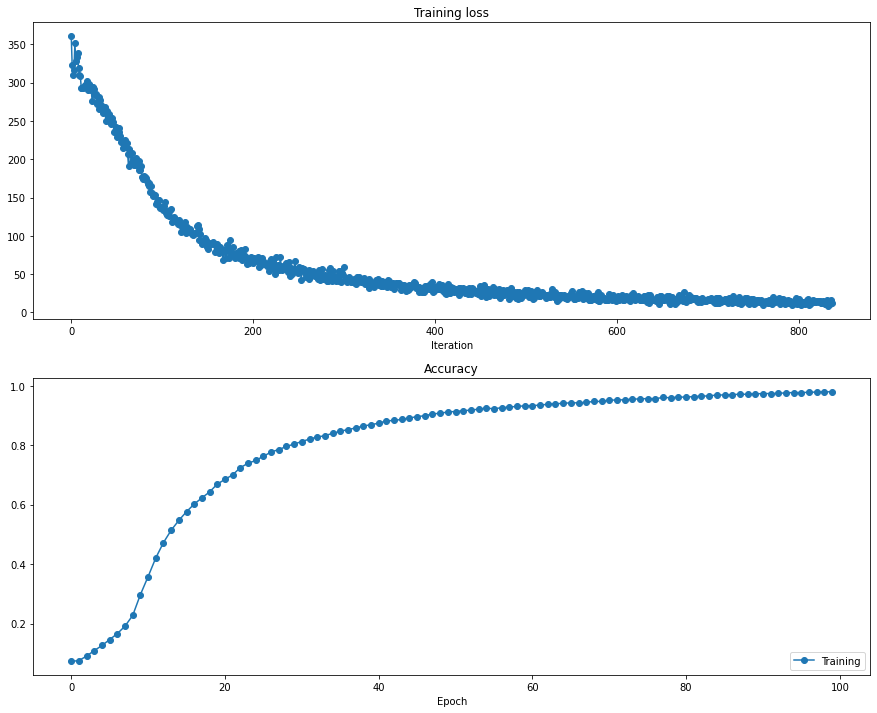

In [76]:
%reload_ext autoreload

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

In [96]:
%reload_ext autoreload

# you can change the generated text length below.
text_length = 99

idx = 0
# you also can start from specific word. 
# since the words are all converted into lower case
idx = int(np.where(np.asarray(word_list) == 'him'.lower())[0])

# sample from the trained model
words = model.sample(idx, text_length-1)

# convert indices into words
output = [word_list[i] for i in words]
output[0] = output[0].capitalize()
print(' '.join(output))

Him in first-class. jack get off safely. as her lifeboat lowers, rose realizes she cannot leave jack, and jumps back on board. cal takes lovejoy's pistol and chases rose and jack into the flooding first-class dining saloon. after using up his ammunition, he relents. cal realizes he gave his coat, and consequently the necklace, to rose. he later boards a lifeboat by carrying a lost child. after braving several obstacles, jack and rose return to the boat deck. the lifeboats have departed and passengers are falling to their deaths as the elder wand, the most powerful wand in history.


### Fun text generations?
[...]